# Neural Network model for fluid dynamics

INTRODUCTION # TODO


As a general guideline for an ML/NN (Machine Learning/Neural Network) project, we follow the A. Géron checklist:

1. Frame the problem and look at the big picture. (In our case: Studying the flow in a channel)
2. Get the data. (As in: Acquiring velocity profiles from experiments)
3. Explore the data to gain insights. (See Section 2 - *Data Download and Inspection*)
4. Prepare the data to expose underlying patterns to Machine Learning algorithms. (Refer to Section 3 - *Downsampling the Database*)
5. Explore different models and shortlist the best ones. (See Section 4 - *Model 1: Binary Classification*)
6. Fine-tune your models and combine them for an optimized solution. (Exercise)
7. Present your solution. (Skipped, as it's not relevant for this lab class)
8. Launch, monitor, and maintain your system. (Skipped, as it's not relevant for this lab class)

## Installing Libraries

We begin by installing the necessary libraries to support our data manipulation, visualization, and deep learning modeling.

In [1]:
%pip install numpy pandas scipy matplotlib

And now we import the necessary libraries

In [2]:
import os  # Operating system-related functions
import pathlib  # Path manipulation and filesystem-related operations

import matplotlib.pyplot as plt  # Data visualization library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # Deep learning framework for neural networks
from tensorflow.keras import Sequential, layers, losses, metrics, optimizers

## Data download and inspection

In this section, we will download the dataset and inspect its components.

### Download dataset files

In [3]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-Re.csv
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-data.csv
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-space.csv

--2023-10-15 15:42:44--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-Re.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1500006 (1.4M) [text/plain]
Saving to: ‘velprof-Re.csv’

velprof-Re.csv      100%[===================>]   1.43M  --.-KB/s    in 0.009s  

2023-10-15 15:42:44 (154 MB/s) - ‘velprof-Re.csv’ saved [1500006/1500006]

--2023-10-15 15:42:44--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

### Read Reynolds (the labels for our model)

We'll start by reading the Reynolds data, which serves as the labels for our model.

In [4]:
data_Re = pd.read_csv("velprof-Re.csv", index_col=False)
data_Re.head()

,Re(-)
0,2950.27502
1,194866.84400
2,104938.95600
3,227933.60600
4,9078.88202


### Read the data file (the features for our model)

Next, we'll read the data file containing the features for our model.

In [5]:
data_v = pd.read_csv("velprof-data.csv", index_col=False)
data_v.head()

,mu(Pas),rho(kg/m3),L(m),R(m),vel[0](m/s),vel[1](m/s),vel[2](m/s),vel[3](m/s),vel[4](m/s),vel[5](m/s),...,vel[40](m/s),vel[41](m/s),vel[42](m/s),vel[43](m/s),vel[44](m/s),vel[45](m/s),vel[46](m/s),vel[47](m/s),vel[48](m/s),vel[49](m/s)
0,0.000630,996.232835,69.244194,0.408814,0.004406,0.004405,0.004399,0.004391,0.004379,0.004363,...,0.001583,0.001433,0.001279,0.001119,0.000954,0.000782,0.000604,0.000418,0.000221,0.0
1,0.001484,1117.370480,94.471272,0.352740,0.429010,0.428980,0.428889,0.428737,0.428525,0.428251,...,0.356270,0.349899,0.342721,0.334513,0.324943,0.313467,0.299106,0.279764,0.249233,0.0
2,0.000372,1039.442220,89.215592,0.248828,0.089278,0.089271,0.089251,0.089217,0.089168,0.089106,...,0.072942,0.071524,0.069930,0.068110,0.065993,0.063462,0.060306,0.056076,0.049453,0.0
3,0.000189,1045.145970,20.190082,0.086718,0.277383,0.277364,0.277306,0.277210,0.277076,0.276902,...,0.231210,0.227158,0.222590,0.217365,0.211269,0.203954,0.194793,0.182441,0.162907,0.0
4,0.002309,1086.237000,17.299562,0.136982,0.090704,0.090693,0.090661,0.090606,0.090530,0.090432,...,0.066148,0.064151,0.061931,0.059432,0.056571,0.053219,0.049142,0.043865,0.036045,0.0


Let's also read another data file that contains information about space discretization, which, in our analogy, represents the probe's position.

In [6]:
data_r = pd.read_csv("velprof-space.csv", index_col=False)
data_r.head()

,r[0](m),r[1](m),r[2](m),r[3](m),r[4](m),r[5](m),r[6](m),r[7](m),r[8](m),r[9](m),...,r[40](m),r[41](m),r[42](m),r[43](m),r[44](m),r[45](m),r[46](m),r[47](m),r[48](m),r[49](m)
0,0.0,0.008343,0.016686,0.025029,0.033373,0.041716,0.050059,0.058402,0.066745,0.075088,...,0.333726,0.342069,0.350412,0.358756,0.367099,0.375442,0.383785,0.392128,0.400471,0.408814
1,0.0,0.007199,0.014398,0.021596,0.028795,0.035994,0.043193,0.050391,0.057590,0.064789,...,0.287951,0.295150,0.302349,0.309548,0.316746,0.323945,0.331144,0.338343,0.345541,0.352740
2,0.0,0.005078,0.010156,0.015234,0.020312,0.025391,0.030469,0.035547,0.040625,0.045703,...,0.203125,0.208203,0.213281,0.218359,0.223437,0.228515,0.233593,0.238672,0.243750,0.248828
3,0.0,0.001770,0.003539,0.005309,0.007079,0.008849,0.010618,0.012388,0.014158,0.015928,...,0.070790,0.072560,0.074329,0.076099,0.077869,0.079639,0.081408,0.083178,0.084948,0.086718
4,0.0,0.002796,0.005591,0.008387,0.011182,0.013978,0.016773,0.019569,0.022364,0.025160,...,0.111822,0.114618,0.117414,0.120209,0.123005,0.125800,0.128596,0.131391,0.134187,0.136982


We can also merge the two datasets, which include both labels and features (it can be useful later).

In [7]:
data_all = pd.concat([data_v, data_Re], axis=1)

### Data Inspection and Visualization

In this section, we will perform the following tasks:
1. Plot a random velocity profile to visually examine the data.
2. Compute and create a correlation matrix plot to analyze the relationships between variables.

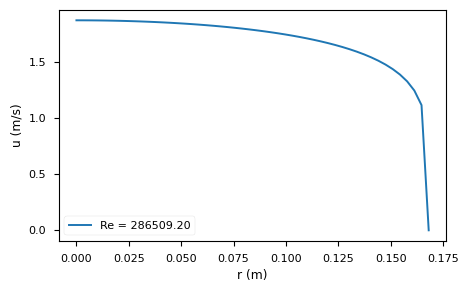

In [12]:
# Create a plot of random data from the datasets
fig = plt.figure(figsize=(5, 3))
indx = np.random.randint(data_v.shape[0] - 1)

# Set the style of the plot to "seaborn-v0_8-paper"
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)

    # Plot the data and labels it with Re value
    ax.plot(
        data_r.iloc[indx, :],
        data_v.iloc[indx, 4:],
        label=f"Re = {data_Re.iloc[indx].values[0]:1.2f}",
    )

    # Add a legend, labels, and titles to the plot
    ax.legend(loc="lower left")
    ax.set_xlabel("r (m)")
    ax.set_ylabel("u (m/s)")

Let's study the data and its correlation

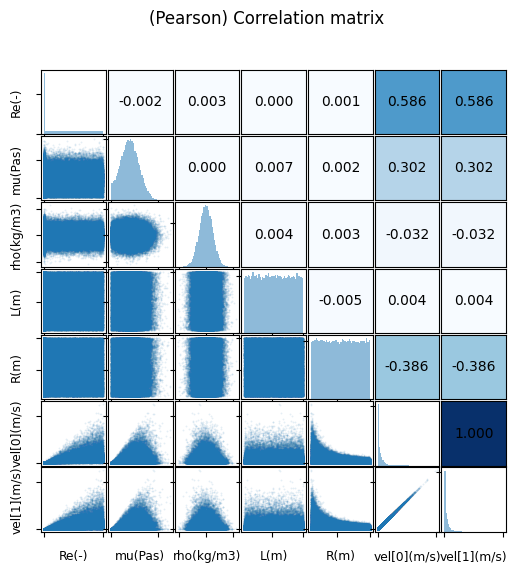

In [13]:
# Correlation Matrix Plot

# Define the number of bins and create a figure
Nbins = 50
fig = plt.figure(figsize=(6, 6))

# Define the labels for the correlation matrix
labels = [
    "Re(-)",
    "mu(Pas)",
    "rho(kg/m3)",
    "L(m)",
    "R(m)",
    "vel[0](m/s)",
    "vel[1](m/s)",
]
N = len(labels)

# Calculate the correlation matrix
corr_matrix = data_all.corr()

# Apply the "seaborn-v0_8-paper" style
with plt.style.context("seaborn-v0_8-paper"):
    grid = fig.add_gridspec(N, N, wspace=0.03, hspace=0.03)
    ax = []
    cmap = plt.get_cmap("Blues")

    for i in range(N):
        for j in range(N):
            ax.append(fig.add_subplot(grid[i, j]))

            # Plot scatter for lower triangle, correlation value for upper triangle, and histograms for diagonal
            if j < i:
                ax[-1].scatter(data_all[labels[j]], data_all[labels[i]], s=1, alpha=0.1)
            elif j > i:
                corr = corr_matrix.loc[labels[j], labels[i]]
                ax[-1].text(0.5, 0.5, f"{corr:1.3f}", ha="center", va="center")
                ax[-1].set_facecolor(cmap(np.abs(corr)))
                ax[-1].set_xticks([])
                ax[-1].set_yticks([])
            else:
                ax[-1].hist(data_all[labels[i]], bins=Nbins, alpha=0.5)

            # Set labels for x and y axes
            if j == 0 or i == N - 1:
                if j == 0 and i != N - 1:
                    ax[-1].set_ylabel(labels[i])
                    ax[-1].set_xticklabels([])
                elif i == N - 1 and j != 0:
                    ax[-1].set_xlabel(labels[j])
                    ax[-1].set_yticklabels([])
                else:
                    ax[-1].set_ylabel(labels[i])
                    ax[-1].set_xlabel(labels[j])

            # Remove tick labels
            ax[-1].set_xticklabels([])
            ax[-1].set_yticklabels([])

    # Set the title for the correlation matrix
    fig.suptitle("(Pearson) Correlation matrix")

# Show the plot
plt.show()

## Downsampling the database

The dataset contains too many data points (100,000), so we will reduce it to 5,000 by randomly selecting from the entire database.

In [14]:
# Get the total number of data points in data_v
Nall = data_v.shape[0]

# Define the desired number of smaller data points to select
Nsmall = 5000

# Initialize a random number generator with a specific seed for reproducibility
rand_gen = np.random.default_rng(seed=1234)

# Generate a random sample of indices without replacement from the range [0, Nall)
# This will be used to select a subset of data_v and data_Re
indx = rand_gen.choice(np.arange(Nall), size=Nsmall, replace=False)

# Create smaller subsets of data_v and data_Re based on the randomly selected indices
data_v_small = data_v.iloc[indx, :]
data_Re_small = data_Re.iloc[indx, :]

let's store it as `.csv` (comma-separated values)

In [15]:
data_v_small.to_csv("small-data.csv", index=False)
data_Re_small.to_csv("small-Re.csv", index=False)

## Model 1: Binary Classification

In this section, we will employ our Neural-Network model for binary classification with the primary goal of distinguishing between turbulent and non-turbulent conditions. It's essential to clarify that, within the context of our database, "non-turbulent" encompasses both laminar and transitional conditions. Please note that for transitional conditions, the velocity profile results are obtained through interpolation, which may exhibit empirical inaccuracy.

### Setup database

We load the features and the labels of our first model.

In [16]:
features = pd.read_csv("small-data.csv", index_col=False).iloc[
    :, 4:
]  # Note: we drop the first 4 columns to study only the velocity profile
labels = pd.read_csv("small-Re.csv", index_col=False)

Display the first few rows of the features.

In [17]:
features.head()

,vel[0](m/s),vel[1](m/s),vel[2](m/s),vel[3](m/s),vel[4](m/s),vel[5](m/s),vel[6](m/s),vel[7](m/s),vel[8](m/s),vel[9](m/s),...,vel[40](m/s),vel[41](m/s),vel[42](m/s),vel[43](m/s),vel[44](m/s),vel[45](m/s),vel[46](m/s),vel[47](m/s),vel[48](m/s),vel[49](m/s)
0,0.028470,0.028458,0.028423,0.028363,0.028280,0.028174,0.028043,0.027889,0.027711,0.027510,...,0.009498,0.008537,0.007553,0.006545,0.005514,0.004458,0.003379,0.002277,0.001150,-0.0
1,0.737167,0.737118,0.736970,0.736723,0.736377,0.735930,0.735382,0.734732,0.733978,0.733118,...,0.618098,0.607614,0.595788,0.582250,0.566443,0.547457,0.523646,0.491484,0.440478,0.0
2,3.295813,3.295619,3.295034,3.294059,3.292691,3.290926,3.288762,3.286193,3.283214,3.279817,...,2.820809,2.778496,2.730667,2.675782,2.611506,2.534025,2.436409,2.303726,2.091186,0.0
3,0.002942,0.002941,0.002937,0.002931,0.002922,0.002911,0.002898,0.002882,0.002863,0.002843,...,0.000981,0.000882,0.000780,0.000676,0.000570,0.000461,0.000349,0.000235,0.000119,-0.0
4,0.009214,0.009210,0.009199,0.009180,0.009153,0.009118,0.009076,0.009026,0.008969,0.008903,...,0.003074,0.002763,0.002445,0.002118,0.001785,0.001443,0.001094,0.000737,0.000372,-0.0


Display the first few rows of the labels.

In [18]:
labels.head()

,Re(-)
0,1932.072390
1,296356.651000
2,862236.727000
3,597.125769
4,1114.249280


Next, we will convert the labels from numerical (`float`) to boolean (`bool`) using the following criteria:

* `True` when the flow is turbulent ($Re \ge 10^4$).
* `False` when the flow is non-turbulent, which includes both laminar and transitional regimes ($Re < 10^4$).

In [19]:
labels_Re = labels.pop("Re(-)")
labels["Turbolent"] = labels_Re >= 1e4

Display the first few rows of the updated labels.

In [20]:
labels.head()

,Turbolent
0,False
1,True
2,True
3,False
4,False


To create a training and test dataset, we perform an 80/20 split.

The purpose of this split is to reserve a portion of the data for testing the model's performance while ensuring that the two sets have a statistically similar distribution of features and labels. Since the database is already shuffled, we can conveniently take the first 1000 data points as the test set, given the total dataset size of 5000 items.

In [21]:
# Splitting the dataset into training and test sets
# Training set (80% of the data)
labels_train = labels.iloc[1000:, :]
features_train = features.iloc[1000:, :]
labels_Re_train = labels_Re.iloc[1000:]

# Test set (20% of the data)
labels_test = labels.iloc[:1000, :]
features_test = features.iloc[:1000, :]
labels_Re_test = labels_Re.iloc[:1000]

### Storing

We will store the datasets and labels in a structured folder for future use.

In [22]:
pathlib.Path("model_1").mkdir(parents=True, exist_ok=True)  # Make a folder
# Make train and test subfolders
pathlib.Path(os.path.join("model_1", "train")).mkdir(exist_ok=True)
pathlib.Path(os.path.join("model_1", "test")).mkdir(exist_ok=True)
# Storing
labels_train.to_csv(os.path.join("model_1", "train", "labels.csv"), index=False)
labels_test.to_csv(os.path.join("model_1", "test", "labels.csv"), index=False)
features_train.to_csv(os.path.join("model_1", "train", "features.csv"), index=False)
features_test.to_csv(os.path.join("model_1", "test", "features.csv"), index=False)

### First Try

#### Building the Model with Keras and TensorFlow

Now we define a function to create our neural network model using Keras and TensorFlow. This involves designing the layers, specifying their connections, and defining their behavior, including activation functions, regularization, dropout, and more.

In a neural network, a *layer* serves as a fundamental building block responsible for processing data and extracting features. Layers are combined to form the architecture of the neural network. Each layer consists of one or more "neurons" (also known as "nodes" or "units").

For our first model, we need to include the following types of layers:

* **Input Layer**: This is the initial layer that receives raw input data. Its primary role is to pass the data to subsequent layers. The input layer typically has one neuron for each feature present in the input data.

* **Hidden Layers**: These intermediate layers sit between the input and output layers. Hidden layers perform complex transformations on the data, enabling the network to learn and extract features from the input. Each neuron in a hidden layer receives input from multiple neurons in the previous layer.

* **Output Layer**: The final layer in the neural network is responsible for producing the model's predictions. The number of neurons in the output layer depends on the nature of the problem being addressed. For binary classification (True/False or 0/1), a single neuron is common in the output layer. In multiclass classification or regression tasks, the number of output neurons can vary.

In addition to layers, we also introduce the concept of an *activation function*. An activation function is a critical element within each neuron of a neural network. It dictates how the output of a neuron is calculated based on its input. The activation function introduces non-linearity into the model, allowing it to learn complex patterns and relationships within the data.

Common activation functions include:

* **ReLU (Rectified Linear Unit)**: ReLU is one of the most widely used activation functions. It returns the input value if it's positive and zero if it's negative. Mathematically, it can be represented as $f(x) = \max(0, x)$. ReLU is effective in training deep networks and addressing the vanishing gradient problem.

* **Sigmoid**: The sigmoid activation function is commonly used in the output layer of binary classification models. It squashes the output into a range between 0 and 1, which can be interpreted as a probability. Mathematically, it's expressed as $f(x) = \dfrac{1}{1 + e^{-x}}$.

* **Tanh (Hyperbolic Tangent)**: Tanh is similar to the sigmoid function but maps values to the range between -1 and 1. It is often used in hidden layers. Mathematically, it's defined as $f(x) = \dfrac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$.

The choice of the activation function depends on the specific problem and the architecture of the network. Each activation function has its own strengths and weaknesses, and selecting the right one is a crucial part of the network design process.

In our case, we use the `relu` (Rectified Linear Unit) activation function in the first hidden layer and a smoother function like `sigmoid` for the output layer.


In [24]:
def build_model_1(n_cols: int) -> tf.keras.models.Sequential:
    """
    Build a the first possible architecture for our neural network model.

    Args:
        n_cols (int): Number of input features.

    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = Sequential(
        [
            # Input layer with the specified input shape
            layers.InputLayer(input_shape=(n_cols,), name="input_layer"),
            # Add the first hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_1"),
            # Add the output layer with a single perceptron (we expect a True/False answer) and sigmoid activation
            layers.Dense(1, activation="sigmoid", name="output_layer"),
        ]
    )
    return model

Let's call the function to build our model.

In [25]:
model = build_model_1(features.shape[1])

#### Model Summary and Structure Visualization

Let's examine the summary of our compiled model and visualize its architecture.

Given that the input data has 50 features and the first hidden layer consists of 64 neurons (each with weights $w$ and biases $b$), we have the following:

- Number of parameters in the first hidden layer ($\mathbf{w}_{h1}$): $50 \times 64 = 3200$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 64 = 64$

In addition, considering the output layer:

- Number of parameters in the output layer weights ($\mathbf{w}_{o}$): $64 \times 1 = 64$
- Number of parameters in the output layer biases ($\mathbf{b}_{o}$): $64 \times 1 = 1$

This results in a total of 3329 degrees of freedom (dofs) within our model.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                3264      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 3329 (13.00 KB)
Trainable params: 3329 (13.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


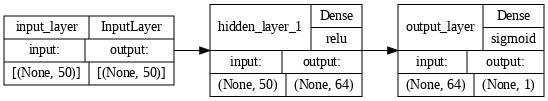

In [27]:
tf.keras.utils.plot_model(
    model=model, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and evaluation metrics.

##### Loss Function

For our binary classification task, we use the Binary Cross-Entropy loss function. The *Binary Cross-Entropy* loss is calculated as:

$\text{Binary Cross-Entropy Loss} = -\frac{1}{N}\sum_{i=1}^{N}\left(y_i \log(p_i) + (1 - y_i) \log(1 - p_i)\right) $

where $N$ is the number of samples, $y_i$ represents the true labels, and $p_i$ is the predicted probability of the positive class.

In [28]:
loss = losses.BinaryCrossentropy(from_logits=True)

##### Optimizer

We use the *Adam* optimizer, a popular choice for training neural networks. The [Adam optimization algorithm](https://doi.org/10.48550/arXiv.1412.6980) is a neural network-specific adaptation of the [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) method.

In [29]:
optimizer = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

##### Metrics

Metrics are functions needed to measure the behavior of our model. There are many to choose from depending on the task of the model. For our case:

- **Accuracy**: This metric measures the overall classification accuracy of the model. It is calculated as the ratio of correct predictions to the total number of samples.

- **Binary Accuracy**: It's a specific metric for binary classification tasks. We use a threshold of 0.5 to determine binary predictions. Binary accuracy is computed as:

$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $

In [30]:
metrics = [
    metrics.Accuracy(),
    metrics.BinaryAccuracy(threshold=0.5),
]


##### Compilation

Finally, we compile the model by specifying the optimizer, loss function, and metrics.

In [31]:
model.compile(
    optimizer,
    loss,
    metrics,
)

#### Training
In training, we define two key parameters:

In [32]:
batch_size = 512
epochs = 100

* **Batch Size**: It specifies the number of training examples used in each iteration. A smaller batch size updates the model more frequently, while a larger one may improve training efficiency but requiring more volatile memory (RAM).

* **Epochs**: Each epoch represents one pass through the entire training dataset. It controls how many times the model iterates over the data, influencing convergence and potential overfitting.

Let's (finally) start the training process.

In [33]:
history = model.fit(
    np.array(features_train),  # before to feed the data we convert it into an array
    np.array(labels_train).astype("float"),
    batch_size,
    epochs,
    validation_data=(
        np.array(features_test),
        np.array(labels_test).astype("float"),
    ),  # test-set
    verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 1s 34ms/step - loss: 0.4915 - accuracy: 0.0402 - binary_accuracy: 0.6440 - val_loss: 0.2811 - val_accuracy: 0.1060 - val_binary_accuracy: 0.6920
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2685 - accuracy: 0.1515 - binary_accuracy: 0.7928 - val_loss: 0.2469 - val_accuracy: 0.1780 - val_binary_accuracy: 0.9420
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.2173 - binary_accuracy: 0.9555 - val_loss: 0.2230 - val_accuracy: 0.2180 - val_binary_accuracy: 0.9670
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2172 - accuracy: 0.2488 - binary_accuracy: 0.9650 - val_loss: 0.1983 - val_accuracy: 0.2560 - val_binary_accuracy: 0.9680
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1937 - accuracy: 0.2743 - binary_accuracy: 0.9657 - val_loss: 0.1728 - val_accuracy: 0.2810 - val_binary_accuracy: 0.9720
Epoch 6/100
8/8 [===================

#### Plot Training Progress

Now, we can plot the training progress.

In [34]:
# Plot traing loop
train_binary_accuracy = np.array(history.history["binary_accuracy"])
test_binary_accuracy = np.array(history.history["val_binary_accuracy"])
train_loss = np.array(history.history["loss"])
test_loss = np.array(history.history["val_loss"])


epochs_i = np.arange(1, train_loss.shape[0] + 1)

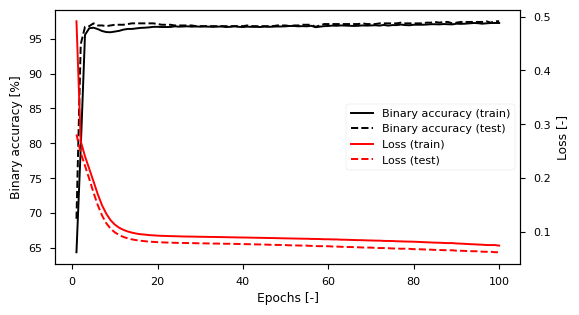

In [37]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    a1 = ax.plot(
        epochs_i,
        train_binary_accuracy * 100,
        color="k",
        ls="-",
        label="Binary accuracy (train)",
    )
    a2 = ax.plot(
        epochs_i,
        test_binary_accuracy * 100,
        color="k",
        ls="--",
        label="Binary accuracy (test)",
    )
    l1 = ax_twin.plot(epochs_i, train_loss, color="r", ls="-", label="Loss (train)")
    l2 = ax_twin.plot(epochs_i, test_loss, color="r", ls="--", label="Loss (test)")
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel("Binary accuracy [%]")
    ax_twin.set_ylabel("Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            "Binary accuracy (train)",
            "Binary accuracy (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="center right",
    )
plt.show()

#### Model result analysis

Let's compare the model's predictions with the Reynolds number.

In [38]:
# Predictions are generated using the model over the test set,
# which the model has never seen during training.
predictions = model.predict(np.array(features_test))

32/32 [==============================] - 0s 1ms/step


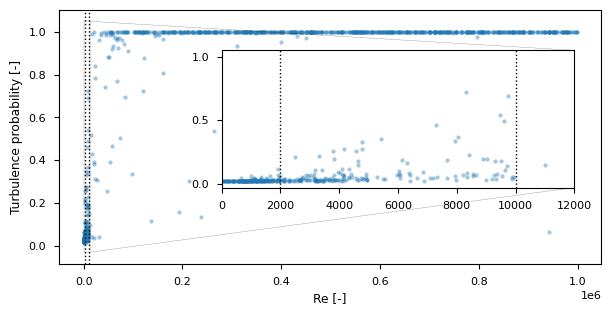

In [40]:
fig = plt.figure(figsize=(7, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.3, 0.3, 0.65, 0.54])
    ax.scatter(labels_Re_test, predictions, s=7, alpha=0.4)
    axins.scatter(labels_Re_test, predictions, s=7, alpha=0.4)
    axins.set_xlim([0, 12000])
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.axvline(2e3, lw=1, color="k", ls=":")
    ax.axvline(1e4, lw=1, color="k", ls=":")
    axins.axvline(2e3, lw=1, color="k", ls=":")
    axins.axvline(1e4, lw=1, color="k", ls=":")
    ax.set_xlabel("Re [-]")
    ax.set_ylabel("Turbulence probability [-]")

In the following code cell, we define functions for deeper analysis, which we can use also later in the project.

In [42]:
def compute_confusion_matrix(labels, predicted):
    """
    Compute the confusion matrix and return its elements along with the indices of TP, TN, FP, and FN.

    Args:
        labels (array-like): The actual binary classification labels (0 or 1).
        predicted (array-like): The predicted binary classification labels (0 or 1).

    Returns:
        numpy.ndarray: The 2x2 confusion matrix.
        list: Indices of True Positives (TP)
        list: Indices of True Negatives (TN)
        list: Indices of False Positives (FP)
        list: Indices of False Negatives (FN)
    """
    if len(labels) != len(predicted):
        raise ValueError("Input arrays must have the same length.")

    confusion_matrix = np.zeros((2, 2), dtype=int)
    TP_indices, TN_indices, FP_indices, FN_indices = [], [], [], []

    for i, (l, p) in enumerate(zip(labels, predicted)):
        confusion_matrix[l][p] += 1
        if l == 1 and p == 1:
            TP_indices.append(i)
        elif l == 0 and p == 0:
            TN_indices.append(i)
        elif l == 0 and p == 1:
            FP_indices.append(i)
        elif l == 1 and p == 0:
            FN_indices.append(i)

    return confusion_matrix, TP_indices, TN_indices, FP_indices, FN_indices

def plot_conf_matrix(ax, confusion_matrix, class_names, cmap, title="Confusion Matrix"):
    """
    Plot the confusion matrix with percentages.

    Args:
        ax: Matplotlib axes to plot the matrix.
        confusion_matrix (numpy.ndarray): The confusion matrix.
        class_names: Class names for labeling.
        cmap: Colormap for the plot.
        title (str): Title for the plot.
    """
    conf_matrix_perc = (confusion_matrix.T / confusion_matrix.sum(axis=1)).T * 100.0
    cm = ax.imshow(
        conf_matrix_perc, interpolation="nearest", cmap=cmap, vmax=100.0, vmin=0.0
    )
    ax.set_title(title)
    plt.colorbar(cm)

    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks, class_names)
    ax.set_yticks(tick_marks, class_names)
    ax.set_yticklabels(class_names, rotation=90, ha="right", va="center")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(
                j,
                i,
                f"{conf_matrix_perc[i, j]:3.2f} %",
                horizontalalignment="center",
                color="k",
            )

    ax.set_ylabel("True labels")
    ax.set_xlabel("Predicted labels")

def plot_velocity_conf_matrix(axs, cm_indices, velocity, class_names, title):
    """
    Plot velocity profiles for TP, TN, FP, and FN.

    Args:
        axs: Matplotlib axes for subplots.
        cm_indices: Confusion matrix indices.
        velocity: Array of velocity profiles.
        class_names: Class names for labeling.
        title (str): Title for the plot.
    """
    velocity = np.asarray(velocity)
    r = np.linspace(0, 1, velocity.shape[1])
    for i in range(2):
        for j in range(2):
            for k in cm_indices[i][j]:
                axs[i][j].plot(r, velocity[k, :])
            axs[i][j].set_yticks([np.mean(axs[i][j].get_ylim())], [class_names[i]])
            axs[i][j].set_xticks([np.mean(axs[i][j].get_xlim())], [class_names[j]])
            axs[i][j].set_yticklabels(
                [class_names[i]], rotation=90, ha="right", va="center"
            )
    ax.set_ylabel("True labels")
    axs[0][0].set_ylabel("True labels")
    axs[1][1].set_xlabel("Predicted labels")
    axs[0][1].set_xticklabels([])
    axs[0][1].set_yticklabels([])
    axs[1][1].set_yticklabels([])
    axs[0][0].yaxis.set_label_coords(-0.22, 0.0, transform=axs[0][0].transAxes)
    axs[1][1].xaxis.set_label_coords(0.0, -0.22, transform=axs[1][1].transAxes)
    axs[0][0].set_title(title, loc="right", fontdict={"ha": "center"})

Now, let's compute the confusion matrix and plot it.

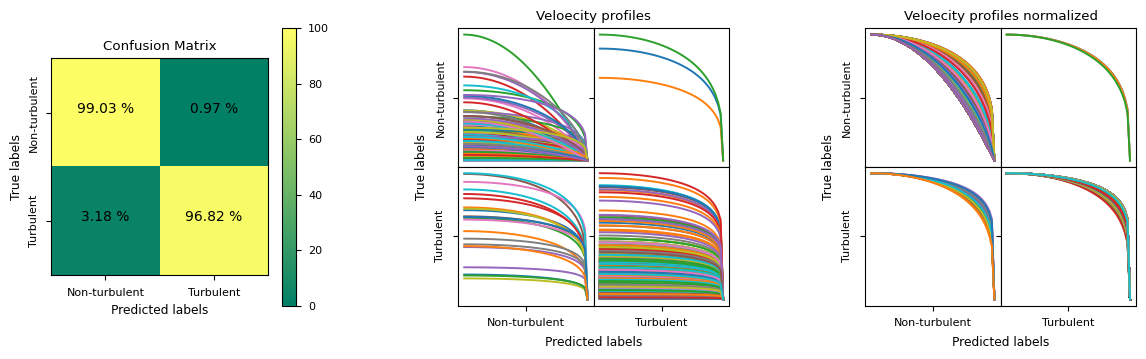

In [44]:
conf_matrix, i_TP, i_TN, i_FP, i_FN = compute_confusion_matrix(
    np.squeeze(np.array(labels_test).astype(int)),
    np.squeeze(predictions > 0.5).astype(int),
)

fig = plt.figure(figsize=(14, 3.6))
with plt.style.context("seaborn-v0_8-paper"):
    grid = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.0)
    ax_cm = fig.add_subplot(grid[:, :2])
    plot_conf_matrix(ax_cm, conf_matrix, ["Non-turbulent", "Turbulent"], "summer")
    ax_cm_p = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 3]))
        ax_cm_p.append(ax_)

    ax_cm_pn = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 6]))
        ax_cm_pn.append(ax_)

    cm_i = [[i_TN, i_FP], [i_FN, i_TP]]
    plot_velocity_conf_matrix(
        ax_cm_p, cm_i, features_test, ["Non-turbulent", "Turbulent"], "Veloecity profiles"
    )
    plot_velocity_conf_matrix(
        ax_cm_pn,
        cm_i,
        (features_test.T / features_test.max(axis=1).values).T,
        ["Non-turbulent", "Turbulent"],
        "Veloecity profiles normalized",
    )


plt.show()

### What if we increse the model depth

We are going to add a hiden layer

In [45]:
def build_model_1_deeper(n_cols):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(n_cols,), name="in"),
            tf.keras.layers.Dense(64, activation="relu", name="h1"),
            tf.keras.layers.Dense(64, activation="relu", name="h2"),
            tf.keras.layers.Dense(1, activation="sigmoid", name="out"),
        ]
    )
    return model

Let us call the function and build the model

In [46]:
model_v1 = build_model_1_deeper(features.shape[1])

And let us see if if is all in order

In [47]:
model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 64)                3264      
                                                                 
 h2 (Dense)                  (None, 64)                4160      
                                                                 
 out (Dense)                 (None, 1)                 65        
                                                                 
Total params: 7489 (29.25 KB)
Trainable params: 7489 (29.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


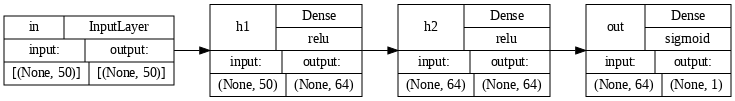

In [48]:
tf.keras.utils.plot_model(
    model=model_v1, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

Now we compile the model

In [49]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
]

model_v1.compile(
    optimizer,
    loss,
    metrics,
)

Training

In [50]:
batch_size = 512
epochs = 100

In [51]:
history_v1 = model_v1.fit(
    np.array(features_train),  # before to feed the data we convert it into an array
    np.array(labels_train).astype("float"),
    batch_size,
    epochs,
    validation_data=(
        np.array(features_test),
        np.array(labels_test).astype("float"),
    ),  # test-set
    verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 1s 30ms/step - loss: 0.3005 - accuracy: 0.1587 - binary_accuracy: 0.7995 - val_loss: 0.2274 - val_accuracy: 0.3490 - val_binary_accuracy: 0.9660
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2108 - accuracy: 0.4042 - binary_accuracy: 0.9607 - val_loss: 0.1729 - val_accuracy: 0.4720 - val_binary_accuracy: 0.9650
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1534 - accuracy: 0.4848 - binary_accuracy: 0.9643 - val_loss: 0.1105 - val_accuracy: 0.5190 - val_binary_accuracy: 0.9720
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1063 - accuracy: 0.5282 - binary_accuracy: 0.9655 - val_loss: 0.0834 - val_accuracy: 0.5620 - val_binary_accuracy: 0.9720
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0986 - accuracy: 0.5608 - binary_accuracy: 0.9665 - val_loss: 0.0806 - val_accuracy: 0.5690 - val_binary_accuracy: 0.9700
Epoch 6/100
8/8 [=================

Now we plot the training

In [52]:
# Plot traing loop
train_binary_accuracy_v1 = np.array(history_v1.history["binary_accuracy"])
test_binary_accuracy_v1 = np.array(history_v1.history["val_binary_accuracy"])
train_loss_v1 = np.array(history_v1.history["loss"])
test_loss_v1 = np.array(history_v1.history["val_loss"])


epochs_i = np.arange(1, train_loss_v1.shape[0] + 1)

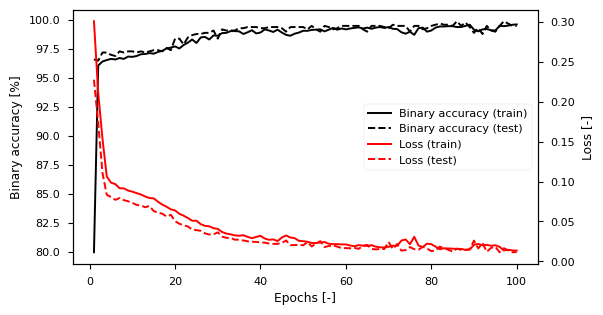

In [53]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    a1 = ax.plot(
        epochs_i,
        train_binary_accuracy_v1 * 100,
        color="k",
        ls="-",
        label="Binary accuracy (train)",
    )
    a2 = ax.plot(
        epochs_i,
        test_binary_accuracy_v1 * 100,
        color="k",
        ls="--",
        label="Binary accuracy (test)",
    )
    l1 = ax_twin.plot(epochs_i, train_loss_v1, color="r", ls="-", label="Loss (train)")
    l2 = ax_twin.plot(epochs_i, test_loss_v1, color="r", ls="--", label="Loss (test)")
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel("Binary accuracy [%]")
    ax_twin.set_ylabel("Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            "Binary accuracy (train)",
            "Binary accuracy (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="center right",
    )
plt.show()

Now we compere the prediction respect the Reynolds number

In [54]:
predictions_v1 = model_v1.predict(np.array(features_test))

32/32 [==============================] - 0s 1ms/step


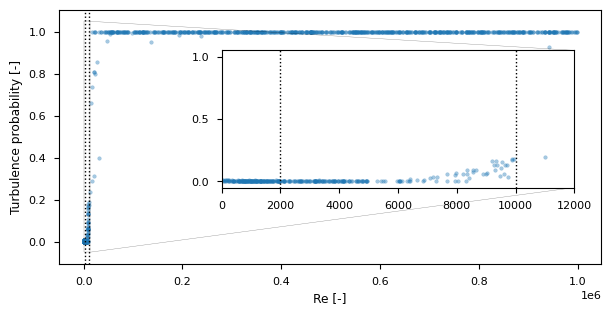

In [56]:
fig = plt.figure(figsize=(7, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.3, 0.3, 0.65, 0.54])
    ax.scatter(labels_Re_test, predictions_v1, s=7, alpha=0.4)
    axins.scatter(labels_Re_test, predictions_v1, s=7, alpha=0.4)
    axins.set_xlim([0, 12000])
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.axvline(2e3, lw=1, color="k", ls=":")
    ax.axvline(1e4, lw=1, color="k", ls=":")
    axins.axvline(2e3, lw=1, color="k", ls=":")
    axins.axvline(1e4, lw=1, color="k", ls=":")
    ax.set_xlabel("Re [-]")
    ax.set_ylabel("Turbulence probability [-]")

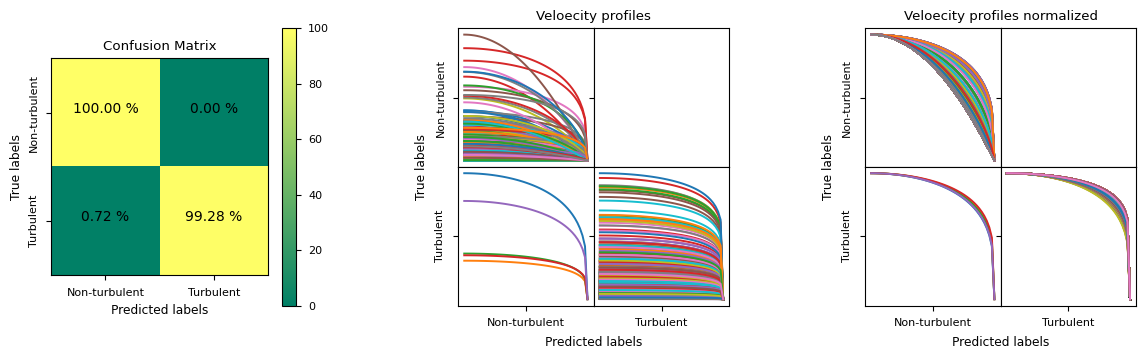

In [58]:
conf_matrix, i_TP, i_TN, i_FP, i_FN = compute_confusion_matrix(
    np.squeeze(np.array(labels_test).astype(int)),
    np.squeeze(predictions_v1 > 0.5).astype(int),
)

fig = plt.figure(figsize=(14, 3.6))
with plt.style.context("seaborn-v0_8-paper"):
    grid = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.0)
    ax_cm = fig.add_subplot(grid[:, :2])
    plot_conf_matrix(ax_cm, conf_matrix, ["Non-turbulent", "Turbulent"], "summer")
    ax_cm_p = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 3]))
        ax_cm_p.append(ax_)

    ax_cm_pn = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 6]))
        ax_cm_pn.append(ax_)

    cm_i = [[i_TN, i_FP], [i_FN, i_TP]]
    plot_velocity_conf_matrix(
        ax_cm_p, cm_i, features_test, ["Non-turbulent", "Turbulent"], "Veloecity profiles"
    )
    plot_velocity_conf_matrix(
        ax_cm_pn,
        cm_i,
        (features_test.T / features_test.max(axis=1).values).T,
        ["Non-turbulent", "Turbulent"],
        "Veloecity profiles normalized",
    )


plt.show()

### What if we increade the database

Let's build a medium size database with 40'000 points



In [59]:
Nall = data_v.shape[0]
Nsmall = 40000

rand_gen = np.random.default_rng(seed=1234)
indx = rand_gen.choice(np.arange(Nall), size=Nsmall, replace=False)

data_v_medium = data_v.iloc[indx, :]
data_Re_medium = data_Re.iloc[indx, :]

let's store it

In [60]:
data_v_medium.to_csv("medium-data.csv", index=False)
data_Re_medium.to_csv("medium-Re.csv", index=False)

as before we reload the data for the *features* and the *labels* of our model, and split it in training and test set



In [61]:
features_v2 = pd.read_csv("medium-data.csv", index_col=False).iloc[
    :, 4:
]  # note: we drop the first 4 colomns to study only the velocity profile
labels_v2 = pd.read_csv("medium-Re.csv", index_col=False)

In [62]:
labels_Re_v2 = labels_v2.pop("Re(-)")
labels_v2["Turbolent"] = labels_Re_v2 >= 1e4

In [63]:
labels_train_v2 = labels_v2.iloc[8000:, :]
labels_test_v2 = labels_v2.iloc[:8000, :]
features_train_v2 = features_v2.iloc[8000:, :]
features_test_v2 = features_v2.iloc[:8000, :]
# the Re number will be useful later
labels_Re_train_v2 = labels_Re_v2.iloc[8000:]
labels_Re_test_v2 = labels_Re_v2.iloc[:8000]

Storing

In [64]:
pathlib.Path("model_1").mkdir(parents=True, exist_ok=True)  # make a folder
# make train and test subfolder
pathlib.Path(os.path.join("model_1", "train")).mkdir(exist_ok=True)
pathlib.Path(os.path.join("model_1", "test")).mkdir(exist_ok=True)
# storin
labels_train.to_csv(os.path.join("model_1", "train", "labels_v2.csv"), index=False)
labels_test.to_csv(os.path.join("model_1", "test", "labels_v2.csv"), index=False)
features_train.to_csv(os.path.join("model_1", "train", "features_v2.csv"), index=False)
features_test.to_csv(os.path.join("model_1", "test", "features_v2.csv"), index=False)

We now build the intila version of our model and compile it

In [65]:
model_v2 = build_model_1(features_v2.shape[1])

In [66]:
model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                3264      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 3329 (13.00 KB)
Trainable params: 3329 (13.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


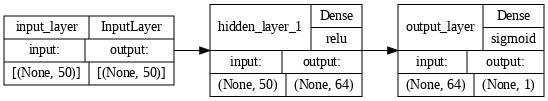

In [67]:
tf.keras.utils.plot_model(
    model=model_v2, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

In [68]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
]

model_v2.compile(
    optimizer,
    loss,
    metrics,
)

Training

In [69]:
batch_size = 512
epochs = 100

In [70]:
history_v2 = model_v2.fit(
    np.array(features_train_v2),  # before to feed the data we convert it into an array
    np.array(labels_train_v2).astype("float"),
    batch_size,
    epochs,
    validation_data=(
        np.array(features_test_v2),
        np.array(labels_test_v2).astype("float"),
    ),  # test-set
    verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 1s 5ms/step - loss: 0.2448 - accuracy: 0.2355 - binary_accuracy: 0.9032 - val_loss: 0.1373 - val_accuracy: 0.3509 - val_binary_accuracy: 0.9632
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1030 - accuracy: 0.4156 - binary_accuracy: 0.9663 - val_loss: 0.0908 - val_accuracy: 0.4600 - val_binary_accuracy: 0.9653
Epoch 3/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0837 - accuracy: 0.4850 - binary_accuracy: 0.9698 - val_loss: 0.0851 - val_accuracy: 0.4904 - val_binary_accuracy: 0.9679
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0807 - accuracy: 0.5008 - binary_accuracy: 0.9706 - val_loss: 0.0833 - val_accuracy: 0.4952 - val_binary_accuracy: 0.9686
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.5026 - binary_accuracy: 0.9711 - val_loss: 0.0820 - val_accuracy: 0.4995 - val_binary_accuracy: 0.9693
Epoch 6/100
63/63 [========

Now we perfome the usual analisys

In [71]:
# Plot traing loop
train_binary_accuracy_v2 = np.array(history_v2.history["binary_accuracy"])
test_binary_accuracy_v2 = np.array(history_v2.history["val_binary_accuracy"])
train_loss_v2 = np.array(history_v2.history["loss"])
test_loss_v2 = np.array(history_v2.history["val_loss"])


epochs_i = np.arange(1, train_loss_v2.shape[0] + 1)

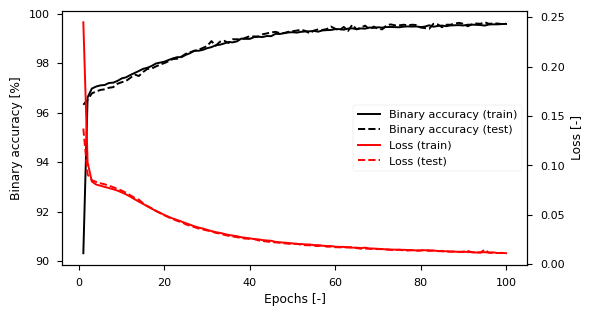

In [73]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    a1 = ax.plot(
        epochs_i,
        train_binary_accuracy_v2 * 100,
        color="k",
        ls="-",
        label="Binary accuracy (train)",
    )
    a2 = ax.plot(
        epochs_i,
        test_binary_accuracy_v2 * 100,
        color="k",
        ls="--",
        label="Binary accuracy (test)",
    )
    l1 = ax_twin.plot(epochs_i, train_loss_v2, color="r", ls="-", label="Loss (train)")
    l2 = ax_twin.plot(epochs_i, test_loss_v2, color="r", ls="--", label="Loss (test)")
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel("Binary accuracy [%]")
    ax_twin.set_ylabel("Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            "Binary accuracy (train)",
            "Binary accuracy (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="center right",
    )
plt.show()

In [74]:
predictions_v2 = model.predict(np.array(features_test_v2))

250/250 [==============================] - 0s 1ms/step


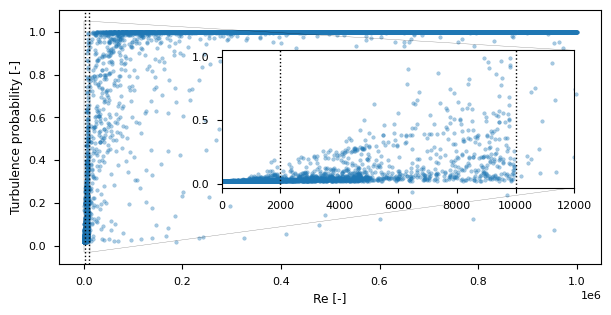

In [76]:
fig = plt.figure(figsize=(7, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.3, 0.3, 0.65, 0.54])
    ax.scatter(labels_Re_test_v2, predictions_v2, s=7, alpha=0.4)
    axins.scatter(labels_Re_test_v2, predictions_v2, s=7, alpha=0.4)
    axins.set_xlim([0, 12000])
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.axvline(2e3, lw=1, color="k", ls=":")
    ax.axvline(1e4, lw=1, color="k", ls=":")
    axins.axvline(2e3, lw=1, color="k", ls=":")
    axins.axvline(1e4, lw=1, color="k", ls=":")
    ax.set_xlabel("Re [-]")
    ax.set_ylabel("Turbulence probability [-]")

Futher analysis

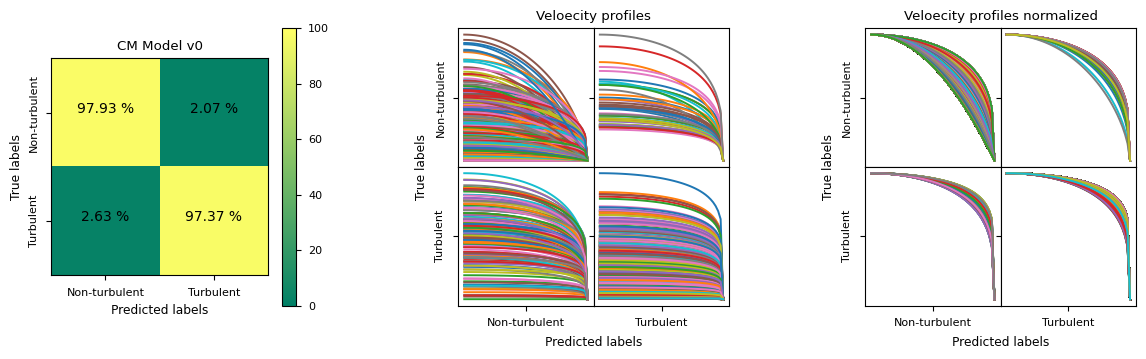

In [77]:
conf_matrix, i_TP, i_TN, i_FP, i_FN = compute_confusion_matrix(
    np.squeeze(np.array(labels_test_v2).astype(int)),
    np.squeeze(predictions_v2 > 0.5).astype(int),
)

fig = plt.figure(figsize=(14, 3.6))
with plt.style.context("seaborn-v0_8-paper"):
    grid = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.0)
    ax_cm = fig.add_subplot(grid[:, :2])
    plot_conf_matrix(
        ax_cm, conf_matrix, ["Non-turbulent", "Turbulent"], "summer", title="CM Model v0"
    )
    ax_cm_p = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 3]))
        ax_cm_p.append(ax_)

    ax_cm_pn = []
    for i in range(2):
        ax_ = []
        for j in range(2):
            ax_.append(fig.add_subplot(grid[i, j + 6]))
        ax_cm_pn.append(ax_)

    cm_i = [[i_TN, i_FP], [i_FN, i_TP]]
    plot_velocity_conf_matrix(
        ax_cm_p, cm_i, features_test_v2, ["Non-turbulent", "Turbulent"], "Veloecity profiles"
    )
    plot_velocity_conf_matrix(
        ax_cm_pn,
        cm_i,
        (features_test_v2.T / features_test_v2.max(axis=1).values).T,
        ["Non-turbulent", "Turbulent"],
        "Veloecity profiles normalized",
    )

    plt.show()

### Conclusion

Let's compare the 3 setup

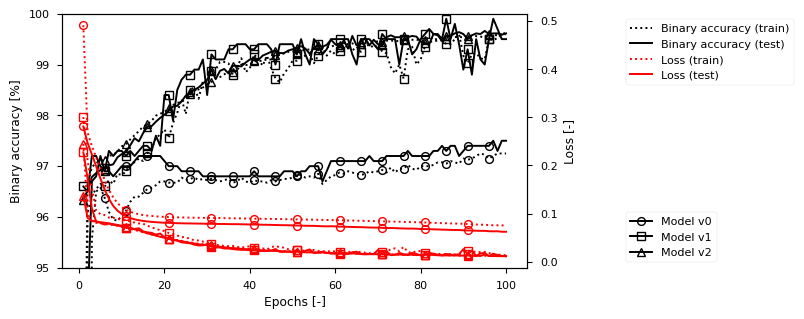

In [80]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    ax_twin.plot(np.nan, np.nan, color="k", ls=":", label="Binary accuracy (train)")
    ax_twin.plot(np.nan, np.nan, color="k", ls="-", label="Binary accuracy (test)")
    ax_twin.plot(np.nan, np.nan, color="r", ls=":", label="Loss (train)")
    ax_twin.plot(np.nan, np.nan, color="r", ls="-", label="Loss (test)")
    ax.plot(
        epochs_i,
        train_binary_accuracy * 100,
        color="k",
        ls=":",
        marker="o",
        markevery=5,
        mfc="none",
        mew=1,
    )
    ax.plot(
        epochs_i,
        train_binary_accuracy_v1 * 100,
        color="k",
        ls=":",
        marker="s",
        markevery=5,
        mfc="none",
        mew=1,
    )
    ax.plot(
        epochs_i,
        train_binary_accuracy_v2 * 100,
        color="k",
        ls=":",
        marker="^",
        markevery=5,
        mfc="none",
        mew=1,
    )
    ax.plot(
        epochs_i,
        test_binary_accuracy * 100,
        color="k",
        ls="-",
        marker="o",
        markevery=5,
        mfc="none",
        mew=1,
        label="Model v0",
    )
    ax.plot(
        epochs_i,
        test_binary_accuracy_v1 * 100,
        color="k",
        ls="-",
        marker="s",
        markevery=5,
        mfc="none",
        mew=1,
        label="Model v1",
    )
    ax.plot(
        epochs_i,
        test_binary_accuracy_v2 * 100,
        color="k",
        ls="-",
        marker="^",
        markevery=5,
        mfc="none",
        mew=1,
        label="Model v2",
    )

    ax_twin.plot(
        epochs_i,
        train_loss,
        color="r",
        ls=":",
        marker="o",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax_twin.plot(
        epochs_i,
        train_loss_v1,
        color="r",
        ls=":",
        marker="s",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax_twin.plot(
        epochs_i,
        train_loss_v2,
        color="r",
        ls=":",
        marker="^",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax_twin.plot(
        epochs_i,
        test_loss,
        color="r",
        ls="-",
        marker="o",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax_twin.plot(
        epochs_i,
        test_loss_v1,
        color="r",
        ls="-",
        marker="s",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax_twin.plot(
        epochs_i,
        test_loss_v2,
        color="r",
        ls="-",
        marker="^",
        markevery=10,
        mfc="none",
        mew=1,
    )
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel("Binary accuracy [%]")
    ax.set_ylim([95, 100])
    ax_twin.set_ylabel("Loss [-]")
    ax_twin.legend(loc="upper left", bbox_to_anchor=(1.2, 1.0))
    ax.legend(loc="lower left", bbox_to_anchor=(1.2, 0.0))
    # ax_twin.legend(a1+a2+l1+l2, ['Binary accuracy (train)', 'Binary accuracy (test)', 'Loss (train)', 'Loss (test)'], loc='center right')
plt.show()

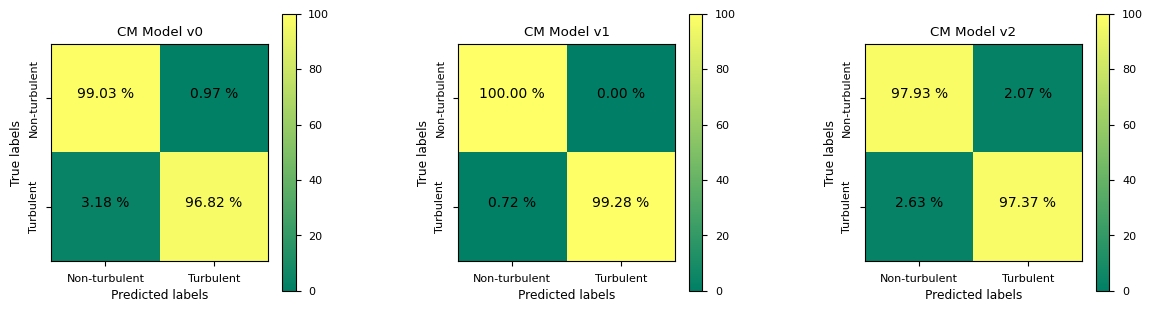

In [81]:
conf_matrix, _, _, _, _ = compute_confusion_matrix(
    np.squeeze(np.array(labels_test).astype(int)),
    np.squeeze(predictions > 0.5).astype(int),
)
conf_matrix_v1, _, _, _, _ = compute_confusion_matrix(
    np.squeeze(np.array(labels_test).astype(int)),
    np.squeeze(predictions_v1 > 0.5).astype(int),
)
conf_matrix_v2, _, _, _, _ = compute_confusion_matrix(
    np.squeeze(np.array(labels_test_v2).astype(int)),
    np.squeeze(predictions_v2 > 0.5).astype(int),
)

fig = plt.figure(figsize=(14, 3.6))
with plt.style.context("seaborn-v0_8-paper"):
    grid = fig.add_gridspec(2, 8, wspace=0.0, hspace=0.0)
    ax_cm_0 = fig.add_subplot(grid[:, :2])
    ax_cm_1 = fig.add_subplot(grid[:, 3:5])
    ax_cm_2 = fig.add_subplot(grid[:, 6:])

    plot_conf_matrix(
        ax_cm_0, conf_matrix, ["Non-turbulent", "Turbulent"], "summer", title="CM Model v0"
    )
    plot_conf_matrix(
        ax_cm_1, conf_matrix_v1, ["Non-turbulent", "Turbulent"], "summer", title="CM Model v1"
    )
    plot_conf_matrix(
        ax_cm_2, conf_matrix_v2, ["Non-turbulent", "Turbulent"], "summer", title="CM Model v2"
    )

    plt.show()